In [61]:
#Import all the libraries
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#import plotly.graph_objs as go
#import plotly.express as px
from scipy.signal import medfilt, butter, filtfilt
import pywt
from sklearn.model_selection import train_test_split
import scipy.signal
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score

In [62]:
#1 Load data
os.chdir('../data') # set working directory to your file's location
dataset = 'Diagnostics.csv'
df=pd.read_csv(dataset)
df.head()





,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354


In [63]:
# 2 - The number of rows and columns for each
print(f"Number of rows :{df.shape[0]} & columns: {df.shape[1]} in Diagnostics dataset")


Number of rows :10646 & columns: 16 in Diagnostics dataset


In [64]:
df.dtypes

FileName           object
Rhythm             object
Beat               object
PatientAge          int64
Gender             object
VentricularRate     int64
AtrialRate          int64
QRSDuration         int64
QTInterval          int64
QTCorrected         int64
RAxis               int64
TAxis               int64
QRSCount            int64
QOnset              int64
QOffset             int64
TOffset             int64
dtype: object

<h1> Feature Engineering</h1>

In [65]:
# 3
'''
 df.count() returns Series with number of non-NA/null observations. 
 And, 'idxmin' would give you column with most non-NA/null values.
'''
print(f" Columns: {df.count().idxmin()} has most missing value in app_test dataset")


 Columns: FileName has most missing value in app_test dataset


In [66]:
missing_value=df.isnull().sum().sort_values(ascending=False)
print(f"Columns name  with value which has highest Missing value in app_test :\n{ missing_value.head(3)}")#print 3 as they have same number
missing_value

Columns name  with value which has highest Missing value in app_test :
FileName    0
Rhythm      0
Beat        0
dtype: int64


FileName           0
Rhythm             0
Beat               0
PatientAge         0
Gender             0
VentricularRate    0
AtrialRate         0
QRSDuration        0
QTInterval         0
QTCorrected        0
RAxis              0
TAxis              0
QRSCount           0
QOnset             0
QOffset            0
TOffset            0
dtype: int64

NONE                  5419
TWC                    775
LVHV                   577
STTC                   429
RBBB                   189
                      ... 
1AVB STDD STTC TWC       1
ABI STTC                 1
ALS LBBB LVQRSCL         1
ALS CCR STTC             1
VFW                      1
Name: Beat, Length: 742, dtype: int64


<AxesSubplot:ylabel='None'>

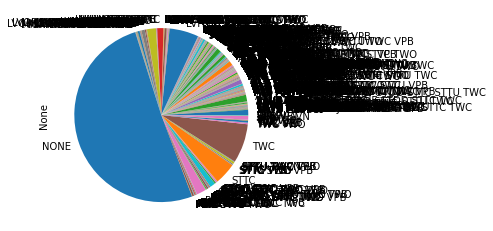

In [67]:
# 5 - value counts
c=df['Beat'].value_counts()
print(c)
# 5 - histograms
df.groupby('Beat').size().plot(kind='pie')

In [68]:
import plotly.express as px
cut_counts = df['Beat'].value_counts()
fig = px.bar( y=cut_counts)
fig.show()

In [69]:
df.head()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354


In [70]:
category_counts = df['Beat'].value_counts()
# Get the category with the highest count
#highest_count_category = category_counts.idxmax()

# Create a new column to store the converted categories
df['Target'] = 1

# Assign the highest count category to one category and "red" category to another category
df.loc[df['Beat'] == 'NONE', 'Target'] = 0

df

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset,Target
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386,1
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431,1
2,MUSE_20180111_165520_97000,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415,0
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447,0
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10641,MUSE_20181222_204306_99000,SVT,NONE,80,FEMALE,196,73,168,284,513,258,244,32,177,261,319,0
10642,MUSE_20181222_204309_22000,SVT,NONE,81,FEMALE,162,81,162,294,482,110,-75,27,173,254,320,0
10643,MUSE_20181222_204310_31000,SVT,NONE,39,MALE,152,92,152,340,540,250,38,25,208,284,378,0
10644,MUSE_20181222_204312_58000,SVT,NONE,76,MALE,175,178,128,310,529,98,-83,29,205,269,360,0


0    5419
1    5227
Name: Target, dtype: int64


array([[<AxesSubplot:title={'center':'Target'}>]], dtype=object)

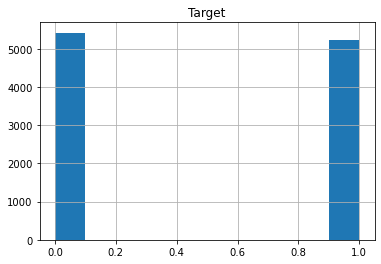

In [71]:
# 5 - value counts
c=df['Target'].value_counts()
print(c)
# 5 - histograms
df.hist(column="Target")

In [72]:
## Your code here
df_org =df.copy()

In [73]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44) #70% training 30% testing
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest.fit(X_train, y_train)
predicted = random_forest.predict(X_test)
result = classification_report(y_test, predicted)
print(result)

KeyError: "['TARGET'] not found in axis"